# 3. Layout detection and Order reading

**Author:** Manel Carrillo, 

**Mail** manelcarrillomaillo@gmail.com

## Imports

In [1]:
from PIL import Image
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import dataclass
from typing import List, Dict, Any
import os
from matplotlib import colormaps
from paddleocr import PaddleOCR
from IPython.display import display
import pandas as pd
from pytesseract import Output
from paddleocr import LayoutDetection
from PIL import Image, ImageOps, ImageEnhance

C:\Users\manel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Checking connectivity to the model hosters, this may take a while. To bypass this check, set `PADDLE_PDX_DISABLE_MODEL_SOURCE_CHECK` to `True`.


## Paths


In [2]:
ocr = PaddleOCR(lang='en')
PATH1 = 'c:/Users/manel/OneDrive/Escritorio/OCR/DocumentAgent/data/images/page_1.png'
PATH2 = 'c:/Users/manel/OneDrive/Escritorio/OCR/DocumentAgent/data/images/page_2.png'
PATH3 = 'c:/Users/manel/OneDrive/Escritorio/OCR/DocumentAgent/data/images/page_3.png'
PATH4 = 'c:/Users/manel/OneDrive/Escritorio/OCR/DocumentAgent/data/images/page_7.png'
PATH5 = 'c:/Users/manel/OneDrive/Escritorio/OCR/DocumentAgent/data/images/TFG1.png'

C:\Users\manel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\paddle\utils\cpp_extension\extension_utils.py:718: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\manel\.paddlex\official_models\PP-LCNet_x1_0_doc_ori`.
Creating model: ('UVDoc', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\manel\.paddlex\official_models\UVDoc`.
Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\manel\.paddlex\offici

## Functions from paddleOCR notebook

### 1 Plain OCR

In [8]:
from dataclasses import dataclass
from typing import Any, Dict, List, Optional, Sequence, Tuple, Union
import numpy as np
import cv2
import matplotlib.pyplot as plt

# -----------------------------
# Data model
# -----------------------------
@dataclass(frozen=True)
class OCRRegion:
    text: str
    bbox: List[List[int]]          # polygon: [[x,y], [x,y], [x,y], [x,y]] (or more points)
    confidence: float
    idx: int = -1                  # original index in Paddle outputs (optional)
    source: str = "paddle"         # useful later when fusing OCRs

    @property
    def bbox_xyxy(self) -> List[int]:
        """Polygon bbox -> [x1, y1, x2, y2]."""
        xs = [p[0] for p in self.bbox]
        ys = [p[1] for p in self.bbox]
        return [int(min(xs)), int(min(ys)), int(max(xs)), int(max(ys))]

    @property
    def w(self) -> int:
        x1, _, x2, _ = self.bbox_xyxy
        return max(0, x2 - x1)

    @property
    def h(self) -> int:
        _, y1, _, y2 = self.bbox_xyxy
        return max(0, y2 - y1)

    @property
    def area(self) -> int:
        return self.w * self.h

    @property
    def center(self) -> Tuple[float, float]:
        x1, y1, x2, y2 = self.bbox_xyxy
        return ((x1 + x2) / 2.0, (y1 + y2) / 2.0)

    def as_dict(self) -> Dict[str, Any]:
        """Serializable form for JSON/RAG."""
        return {
            "idx": self.idx,
            "text": self.text,
            "confidence": float(self.confidence),
            "bbox_poly": self.bbox,
            "bbox_xyxy": self.bbox_xyxy,
            "source": self.source,
        }


# -----------------------------
# Core Paddle extraction
# -----------------------------
def extract_page_fields(result: Sequence[Dict[str, Any]], page_idx: int = 0):
    """
    Extract PaddleOCR page fields with basic validation.
    Returns: (page, texts, scores, boxes, img_or_none)
    """
    if result is None or len(result) == 0:
        raise ValueError("PaddleOCR result is empty (None or len=0).")

    if page_idx < 0 or page_idx >= len(result):
        raise IndexError(f"page_idx={page_idx} out of range. result has {len(result)} pages.")

    page = result[page_idx]
    required = ("rec_texts", "rec_scores", "rec_polys")
    missing = [k for k in required if k not in page]
    if missing:
        raise KeyError(f"Missing keys in page dict: {missing}. Available keys: {list(page.keys())}")

    texts = page["rec_texts"]
    scores = page["rec_scores"]
    boxes = page["rec_polys"]

    if not (len(texts) == len(scores) == len(boxes)):
        raise ValueError(
            f"Length mismatch: texts={len(texts)}, scores={len(scores)}, boxes={len(boxes)}"
        )

    img = None
    # optional preprocessed image
    try:
        img = page.get("doc_preprocessor_res", {}).get("output_img", None)
    except Exception:
        img = None

    return page, texts, scores, boxes, img


def build_ocr_regions(
    texts: Sequence[str],
    scores: Sequence[float],
    boxes: Sequence[np.ndarray],
    min_score: float = 0.0,
    keep_empty_text: bool = False,
) -> List[OCRRegion]:
    """Convert Paddle outputs into OCRRegion objects (filtered)."""
    regions: List[OCRRegion] = []
    for i, (t, s, b) in enumerate(zip(texts, scores, boxes)):
        s = float(s)
        if s < min_score:
            continue
        t = "" if t is None else str(t)
        if (not keep_empty_text) and (t.strip() == ""):
            continue

        poly = np.asarray(b).astype(int).tolist()
        regions.append(OCRRegion(text=t, bbox=poly, confidence=s, idx=i, source="paddle"))
    return regions


# -----------------------------
# Printing / Visualization
# -----------------------------
def print_ocr_regions(
    regions: Sequence[OCRRegion],
    top_k: Optional[int] = None,
    sort_by: str = "confidence",      # "confidence" | "top_to_bottom"
    text_width: int = 45,
):
    rows = list(regions)

    if sort_by == "confidence":
        rows.sort(key=lambda r: r.confidence, reverse=True)
    elif sort_by == "top_to_bottom":
        rows.sort(key=lambda r: (r.bbox_xyxy[1], r.bbox_xyxy[0]))  # y1, x1
    else:
        raise ValueError("sort_by must be 'confidence' or 'top_to_bottom'")

    if top_k is not None:
        rows = rows[:top_k]

    print(f"{'idx':>4} | {'text':{text_width}} | {'conf':>6} | bbox_xyxy")
    print("-" * (4 + 3 + text_width + 3 + 6 + 3 + 20))
    for r in rows:
        t = r.text
        t_fmt = (t[: text_width - 1] + "…") if len(t) > text_width else t
        print(f"{r.idx:>4} | {t_fmt:{text_width}} | {r.confidence:6.3f} | {r.bbox_xyxy}")


def draw_ocr_regions(
    img: np.ndarray,
    regions: Sequence[OCRRegion],
    box_thickness: int = 2,
    font_scale: float = 0.55,
    show_text: bool = False,
    show_conf: bool = True,
    max_labels: Optional[int] = 30,   # avoid unreadable mess
) -> np.ndarray:
    if img is None:
        raise ValueError("No image available to draw on (img is None).")

    img_plot = img.copy()
    labeled = 0

    for r in regions:
        pts = np.asarray(r.bbox, dtype=int)
        cv2.polylines(img_plot, [pts], True, (0, 255, 0), box_thickness)

        if show_text and (max_labels is None or labeled < max_labels):
            x, y = int(pts[0][0]), int(pts[0][1])
            label = r.text
            if show_conf:
                label = f"{label} ({r.confidence:.2f})"
            cv2.putText(
                img_plot,
                label,
                (x, max(0, y - 6)),
                cv2.FONT_HERSHEY_SIMPLEX,
                font_scale,
                (255, 0, 0),
                2,
                cv2.LINE_AA,
            )
            labeled += 1

    return img_plot


def show_image(img: np.ndarray, title: Optional[str] = None, figsize=(10, 12)):
    img_show = img
    if img is not None and img.ndim == 3 and img.shape[2] == 3:
        img_show = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=figsize)
    plt.imshow(img_show)
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()


# -----------------------------
# End-to-end runner
# -----------------------------
def run_paddle(
    ocr, 
    image_path: str,
    page_idx: int = 0,
    min_score: float = 0.50,
    top_k: int = 50,
    print_sort_by: str = "confidence",
    visualize: bool = True,
    show_text_on_image: bool = False,
):
    """
    Run PaddleOCR on an image, build OCRRegion objects, print and visualize.
    Returns: (result, page, ocr_regions, img_annot_or_none)
    """
    result = ocr.predict(image_path)
    page, texts, scores, boxes, img = extract_page_fields(result, page_idx=page_idx)

    ocr_regions = build_ocr_regions(texts, scores, boxes, min_score=min_score)

    print(f"Stored {len(ocr_regions)} OCR regions (min_score={min_score}).")
    print_ocr_regions(ocr_regions, top_k=top_k, sort_by=print_sort_by, text_width=45)

    img_annot = None
    if visualize:
        if img is None:
            print("No preprocessed image found at page['doc_preprocessor_res']['output_img'].")
        else:
            img_annot = draw_ocr_regions(
                img,
                ocr_regions,
                show_text=show_text_on_image,
                show_conf=True,
                max_labels=30,
            )
            show_image(img_annot, title="PaddleOCR Regions (Processed Image)")

    return result, page, ocr_regions, img_annot


Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\manel\.paddlex\official_models\PP-LCNet_x1_0_doc_ori`.
Creating model: ('UVDoc', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\manel\.paddlex\official_models\UVDoc`.
Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\manel\.paddlex\official_models\PP-LCNet_x1_0_textline_ori`.
Creating model: ('PP-OCRv5_server_det', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\manel\.paddlex\official_models\PP-OCRv5_server_det`.
Creating model: ('en_PP-OCRv5_mobile_rec', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\manel\.paddlex\

Stored 78 OCR regions (min_score=0).
 idx | text                                          |   conf | bbox_xyxy
------------------------------------------------------------------------------------
   8 | Abstract                                      |  1.000 | [548, 916, 763, 968]
  77 | 1                                             |  1.000 | [1220, 3167, 1252, 3211]
  39 | NVIDIA et al., 2025).                         |  1.000 | [1280, 1840, 1699, 1890]
  38 | long-context performance, which is the scena… |  1.000 | [183, 1827, 1116, 1882]
   9 | 1. Introduction                               |  1.000 | [1281, 916, 1645, 968]
   4 | 1NLP Group, DCST, IAI, BNRIST, Tsinghua Univ… |  0.999 | [431, 631, 1782, 685]
  17 | trast, recurrent neural networks (RNNs) such… |  0.999 | [1280, 1238, 2372, 1291]
  32 | ever, these transfer methods require substan… |  0.999 | [186, 1666, 1115, 1718]
  64 | superior long-context performance and effici… |  0.999 | [184, 2558, 1121, 2611]
  23 | to their

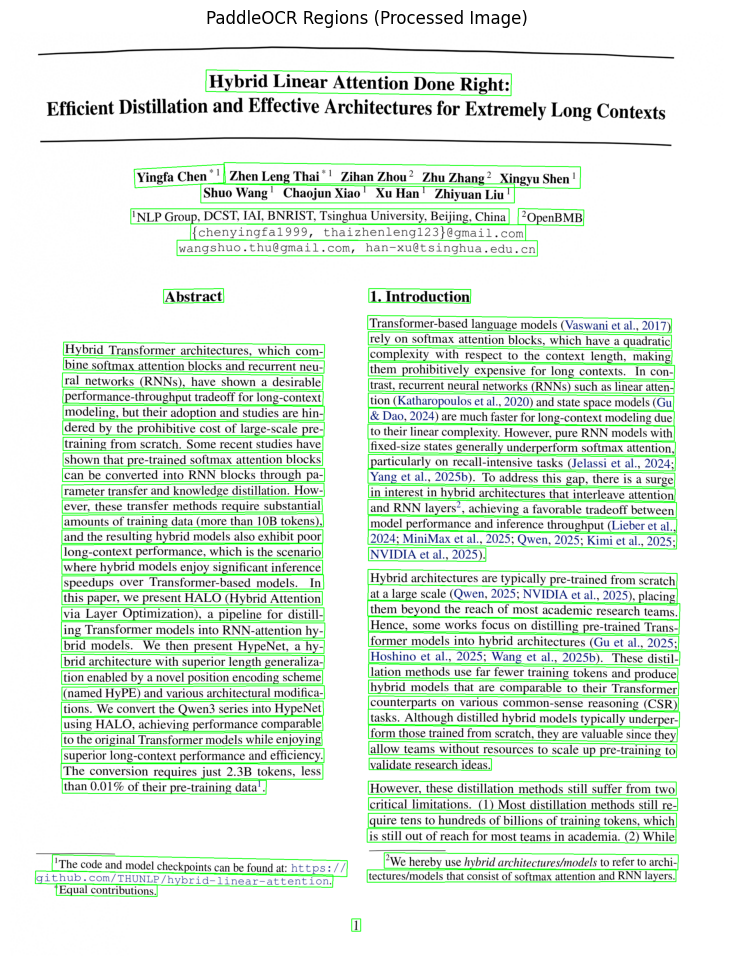

In [11]:
from paddleocr import PaddleOCR
ocr = PaddleOCR(lang="en")

result, page, ocr_regions, img_annot = run_paddle(
    ocr,
    PATH1,
    min_score=0,
    top_k=50,
    print_sort_by="confidence",
    visualize=True,
    show_text_on_image=False,
)

### 2 Layout Detection

In [3]:
layout_engine = LayoutDetection()

Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\manel\.paddlex\official_models\PP-DocLayout_plus-L`.


In [9]:
def extract_layout_regions(
    image_path,
    layout_engine,
    min_confidence=0.0,
    sort_by="confidence"  # "confidence" | "top_to_bottom"
):
    """
    Run layout detection and return structured layout regions.

    Parameters
    ----------
    image_path : str or Path
        Path to input image.
    layout_engine : object
        PaddleOCR layout engine (already initialized).
    min_confidence : float
        Minimum confidence threshold.
    sort_by : str
        Sorting strategy:
        - "confidence": descending confidence
        - "top_to_bottom": reading-order-like (y, then x)

    Returns
    -------
    List[dict]
        Each dict contains: label, score, bbox, cx, cy
    """
    image_path = Path(image_path)
    if not image_path.exists():
        raise FileNotFoundError(f"Image not found: {image_path}")

    layout_result = layout_engine.predict(str(image_path))

    if not layout_result or "boxes" not in layout_result[0]:
        raise ValueError("Invalid layout detection output.")

    regions = []
    for box in layout_result[0]["boxes"]:
        score = float(box["score"])
        if score < min_confidence:
            continue

        x1, y1, x2, y2 = box["coordinate"]
        cx = (x1 + x2) / 2
        cy = (y1 + y2) / 2

        regions.append({
            "label": box["label"],
            "score": score,
            "bbox": [x1, y1, x2, y2],
            "cx": cx,
            "cy": cy
        })

    if sort_by == "confidence":
        regions.sort(key=lambda r: r["score"], reverse=True)
    elif sort_by == "top_to_bottom":
        regions.sort(key=lambda r: (r["cy"], r["cx"]))
    else:
        raise ValueError(f"Unknown sort_by='{sort_by}'")

    return regions

def visualize_layout_regions(
    image_path,
    regions,
    figsize=(10, 12),
    show_labels=True,
    line_thickness=2,
    font_scale=0.6
):
    """
    Visualize layout regions on the image.

    Parameters
    ----------
    image_path : str or Path
        Path to input image.
    regions : List[dict]
        Output from extract_layout_regions.
    """
    image_path = Path(image_path)
    img = cv2.imread(str(image_path))
    if img is None:
        raise ValueError(f"cv2.imread failed for {image_path}")

    img_plot = img.copy()

    labels = sorted(set(r["label"] for r in regions))
    cmap = colormaps.get_cmap("tab20")

    color_map = {
        label: (
            int(cmap(i)[2] * 255),
            int(cmap(i)[1] * 255),
            int(cmap(i)[0] * 255),
        )
        for i, label in enumerate(labels)
    }

    for r in regions:
        x1, y1, x2, y2 = map(int, r["bbox"])
        color = color_map[r["label"]]

        pts = np.array(
            [[x1, y1], [x2, y1], [x2, y2], [x1, y2]],
            dtype=int
        )

        cv2.polylines(img_plot, [pts], True, color, line_thickness)

        if show_labels:
            text = f"{r['label']} ({r['score']:.2f})"
            cv2.putText(
                img_plot,
                text,
                (x1, max(0, y1 - 8)),
                cv2.FONT_HERSHEY_SIMPLEX,
                font_scale,
                color,
                2,
                cv2.LINE_AA
            )

    plt.figure(figsize=figsize)
    plt.imshow(cv2.cvtColor(img_plot, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Layout Detection (PaddleOCR)")
    plt.show()

    return img_plot

In [ ]:
from transformers import LayoutLMv3ForTokenClassification
from layoutreader.v3.helpers import prepare_inputs, boxes2inputs, parse_logits

# Load LayoutReader model
print("Loading LayoutReader model...")
model_slug = "hantian/layoutreader"
layout_model = LayoutLMv3ForTokenClassification.from_pretrained(model_slug)
print("Model loaded successfully!")